# Analysis of results of multi-zone MC simulations of reaction rate uncertainties for NOVA models (Python 3)

In [2]:
%pylab ipympl 

import os 
import sys
import h5py

from scipy import stats
from scipy.stats import norm
from scipy.stats import lognorm
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from nugridpy import nugridse as nuse
from nugridpy import utils
from nugridpy import ppn
from nugridpy import utils

Populating the interactive namespace from numpy and matplotlib


In [3]:
mixing_case = 'MLT'

In [9]:
# a color-blind color set 
CB_color = ['#377eb8', '#ff7f00', '#4daf4a',
            '#f781bf', '#a65628', '#984ea3',
            '#999999', '#e41a1c', '#dede00']

In [ ]:
def get_everything_you_need(mixing_case):
    # the initial abundances for NOVA models are the Asplund et al. (2009) solar abundances 
    upper = "/user/niagara_scratch_fherwig/wendi.user/jissa/multizone/"
    mppnp_test_dir=upper+mixing_case+"_MC_results/"
    
    sol_ab=upper+"../mixing_results/iniab2.0E-02GN93.ppn"
    
    init_ab=sol_ab
    
    utils.solar(sol_ab,1.)
    sol_abu=utils.solar_elem_abund
    n_sol=len(sol_abu)

    # read in initial elemental abundances in the path init_ab
    utils.solar(init_ab,1.)
    init_abu=utils.solar_elem_abund
    n_init=len(init_abu)
    print ("\nn_init =",n_init)

    # read in solar abundances in the path sol_ab
    utils.solar(sol_ab,1.)
    sol_abu=utils.solar_elem_abund
    n_sol=len(sol_abu)
    print ("\nn_sol =",n_sol)
    
    # initial and solar abundances do not include Tc and Pm
    # here we include them with the abundances 1e-99
    
    n_el = n_sol + 2  # n_sol + the unstable Tc (Z=43) and Pm (Z=61)
    
    el_name=["  " for x in range(n_el)]
    z_el=np.linspace(0,0,n_el)
    
    el_name[0]='n'
    for i in range(n_el):
        z_el[i]=float(i)       #  Z=i in mppnp surf data output
        if (i>0):
            el_name[i]=utils.get_el_from_z(i)
    
    # el_abu_init = np.linspace(1e-99,1e-99,n_el)
    el_abu_sol = np.linspace(1e-99,1e-99,n_el)
    
    for i in range(n_el):  
        for k in range(n_sol):
            z_sol=k+1
            if float(z_sol)==z_el[i] and z_sol != 43 and z_sol != 61:  
    #             el_abu_init[i] = init_abu[k]
                el_abu_sol[i] = sol_abu[k]
    
    # print ("X_init =",el_abu_init[1],", X_init(Tc) =", el_abu_init[43],", X_init(Pm) =", el_abu_init[61])
    print ("X_sol =",el_abu_sol[1],", X_sol(Tc) =", el_abu_sol[43],", X_sol(Pm) =", el_abu_sol[61])

    work_dir = mppnp_test_dir

    model = 11200
    
    mc = 0 
    file_name = mixing_case+"_MC_"+str(mc)+"_OC"
    suffix = ".0010001.surf.h5"
    h5_file = work_dir+file_name+suffix
    
    print("Zero variation case:", h5_file)
    with h5py.File(h5_file, 'r') as file:
        dset = file["/cycle"+str(model).zfill(10)+"/SE_DATASET"]
        el_abu_0 = dset['elem_massf_decay'][0]
        iso_abu_0 = dset['iso_massf_decay'][0]
    
    n_el = len(el_abu_0)
    n_iso = len(iso_abu_0)
    
    print ("Number of Elements: ", n_el, "\nNumber of Isotopes:", n_iso)
    
    mc_runs = 1000 # the total number of MC runs
    el_abu = np.zeros((mc_runs,n_el),dtype=float) # this 2d array stores surface abundances from all mc_runs
    iso_abu = np.zeros((mc_runs,n_iso),dtype=float) # this 2d array stores surface abundances from all mc_runs
    
    print('Reading all MC runs')
    for mc in range(mc_runs):
        
        if mc % 100 == 0: print('Reading in run', mc)
    
        mc1 = mc+1
        file_name = mixing_case+"_MC_"+str(mc1)+"_OC"
        h5_file = work_dir+file_name+suffix
        # print (file_name+suffix)
        
        try:
            with h5py.File(h5_file, 'r') as file:
                dset = file["/cycle"+str(model).zfill(10)+"/SE_DATASET"]
                el_abu[mc,:]  = dset['elem_massf_decay'][0]
                iso_abu[mc,:] = dset['iso_massf_decay'][0]
        except:
            print(f"Missing run {mc1}")
            
        
    el_name=["  " for x in range(n_el)]
    z_el=np.linspace(0,0,n_el)
    el_name[0]='n'
    for i in range(n_el):
        z_el[i]=float(i)       #  Z=i in mppnp surf data output
        if (i>0):
            el_name[i]=utils.get_el_from_z(i)

    iso_z=np.linspace(0,0,n_iso)
    iso_a=np.linspace(0,0,n_iso)
    iso_name=["  " for x in range(n_iso)]
    
    mc = 0
    mc1 = mc+1  # this is important !!!
    file_name = mixing_case+"_MC_"+str(mc1)+"_OC"
    
    # Basically, my version of mppnp kills all the header information for some reason.... so run this to get that properly
    
    h5_file = upper+"../mixing_results/"+mixing_case+"_RUNS/hif7.95E+03/my_test_hif.0010001.surf.h5"
    file = h5py.File(h5_file, 'r')
    dseta = file["A"]
    dsetz = file["Z"]
    iso_a[:] = dseta[:]
    iso_z[:] = dsetz[:]
    file.close()
    
    iso_name[0] = 'n'
    iso_name[1] = 'H'
    
    isomers = ['ALm', 'KRm', 'CDm', 'LUm', 'TAm']
    start = n_iso - len(isomers)
    for isomer in isomers: 
        i = isomers.index(isomer)
        iso_name[start+i] = isomer
    
    for i in range(2,n_iso-len(isomers)):
        iz = int(iso_z[i])
        iso_name[i] = utils.get_el_from_z(int(iso_z[i]))
        
    iso_full_name = []
    for i in range(n_iso):
        iso_full_name.append(iso_name[i]+"-"+str(int(iso_a[i])))

    # Read the mult_rtypes file and parse the data
    file_mult = open(mppnp_test_dir + "reaction_factors_mult_rtypes.txt","r")
    
    data = file_mult.readlines()
    
    mult = [x.split() for x in data]
    # print(mult)
    n_mc = 1000 # int(mult[0][0]) # number of combinations of mult factors = mc_runs
    n_fac = int(mult[0][1]) # number of reactions with varied rates
    
    print ("n_mc =", n_mc, "must be equal to mc_runs =", n_mc,
           "\nn_fac =", n_fac, "must be equal to the number of varied reaction rates")
    
    mc_fac = np.zeros((n_mc, n_fac), dtype=float)
    
    nn = 5 # maximum number of array elements per line in the data
    kk = n_fac // nn
    mm = n_fac % nn
    
    nl = n_mc 
    # nl = 2
    
    print(nn, kk, mm, nl)
    
    k1 = 0
    for i in range(nl):
        for k in range(kk):
            k1 += 1
            for n in range(nn):
                m = k * nn + n
                mc_fac[i, m] = float(mult[k1][n].replace('D', 'E'))
        if mm > 0:
            k1 += 1
            for n in range(mm):
                m = kk * nn + n
                mc_fac[i, m] = float(mult[k1][n].replace('D', 'E'))
    
    print("k1 =", k1, "must be equal to", (kk + (1 if mm > 0 else 0)) * n_mc)

    print("These should be equal")
    # check that these factors are the same
    # the first number in the first raw of the list (the file reaction_factors_mult.txt)
    print (mult[1][0], mc_fac[0,0])
    # the last number in the last raw of the list
    print (mult[k1][mm-1], mc_fac[249,n_fac-1]) # the first number in the last raw of the list

    file_mult = open(mppnp_test_dir + "reaction_factors_rtypes.txt","r")
    
    data = file_mult.readlines()
    fac = [x.split() for x in data]
    name = []
    mass = []
    rtypes = []
    varmax = []
    print(fac[-1])
    for k in range(len(fac)):
        if len(fac[k]) == 4:
            name.append(fac[k][0])
            mass.append(fac[k][1])
            rtypes.append(fac[k][2])
            varmax.append(float(fac[k][3]))
        if len(fac[k]) == 3:
            name.append(fac[k][0][0:2])
            mass.append(fac[k][0][2:])
            rtypes.append(fac[k][1])
            varmax.append(float(fac[k][2]))
    
    # print the first and last raws of the file reaction_factors.txt
    k = 0
    print (k, name[k], mass[k], rtypes[k], varmax[k])
    k = len(name)-1
    print (k, name[k], mass[k], rtypes[k], varmax[k])

    return (mc_runs, el_name, z_el, n_el, el_abu_0, el_abu, el_abu_sol,
            n_fac, n_iso, iso_name, iso_a, iso_abu, iso_abu_0,
            mc_fac, name, mass, rtypes, varmax)

In [5]:
mc_runs, el_name, z_el, n_el, el_abu_0, el_abu, el_abu_sol, n_fac, n_iso, iso_name, iso_a, iso_abu, iso_abu_0, mc_fac, name, mass, rtypes, varmax = get_everything_you_need(mixing_case)

This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files

n_init = 83
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files

n_sol = 83
X_sol = 0.706457139998516 , X_sol(Tc) = 1e-99 , X_sol(Pm) = 1e-99
Zero variation case: /user/niagara_scratch_fherwig/wendi.user/jissa/multizone/MLT_MC_results/MLT_MC_0_OC.0010001.surf.h5
Number of Elements:  85 
Number of 

In [7]:
def get_sol_abu(isotopes):    

    def get_sol(sol_ab="/user/niagara_scratch_fherwig/wendi.user/jissa/mixing_results/iniab2.0E-02GN93.ppn"):
        '''
            grab the solar abundances and turn it into a dataframe
        '''
            
        f = open(sol_ab, 'r')
    
        sol_iso_z=[]
        sol_iso=[]
        sol_iso_name = []
        sol_iso_a = []
        sol_iso_abu=[]
    
        for line in f:
            n = len(line.split())
            if n == 3:
                sol_iso = line.split()[1]
                if sol_iso == 'PROT':
                    sol_iso_name.append('h')
                    sol_iso_a.append(1)
                    sol_iso_z.append(int(line.split()[0]))
                    sol_iso_abu.append(float(line.split()[2]))
                else:
                    sol_iso_name.append(sol_iso[0:2])
                    sol_iso_a.append(int(sol_iso[2:5]))
                    sol_iso_z.append(int(line.split()[0]))
                    sol_iso_abu.append(float(line.split()[2]))
            if n == 4:
                sol_iso_z.append(int(line.split()[0]))
                sol_iso_name.append(line.split()[1])
                sol_iso_a.append(int(line.split()[2]))
                sol_iso_abu.append(float(line.split()[3]))
    
        f.close()
    
        df_solar = pd.DataFrame()
        df_solar['Z'] = sol_iso_z
        df_solar['Element'] = sol_iso_name
        df_solar['sol_iso_a'] = sol_iso_a
        df_solar['sol_iso_abu'] = sol_iso_abu
        
        return df_solar

    df_solar = get_sol()
    
    if type(isotopes) == str:
        
        ele, num = isotopes.split('-')
        
        elemask = df_solar.Element == ele.lower()
                
        nummask = df_solar.sol_iso_a == int(num)
        
        mask = elemask & nummask
        
        abu = df_solar[mask].sol_iso_abu.to_numpy()[0]
        
        return abu
    
    else:
        res = []
        for iso in isotopes:
            ele, num = iso.split('-')
        
            elemask = df_solar.Element == ele.lower()

            nummask = df_solar.sol_iso_a == int(num)

            mask = elemask & nummask
            
            abu = df_solar[mask].sol_iso_abu.to_numpy()[0]
            res.append(abu)
            
        return np.array(res)

## List of template isotopic abundances

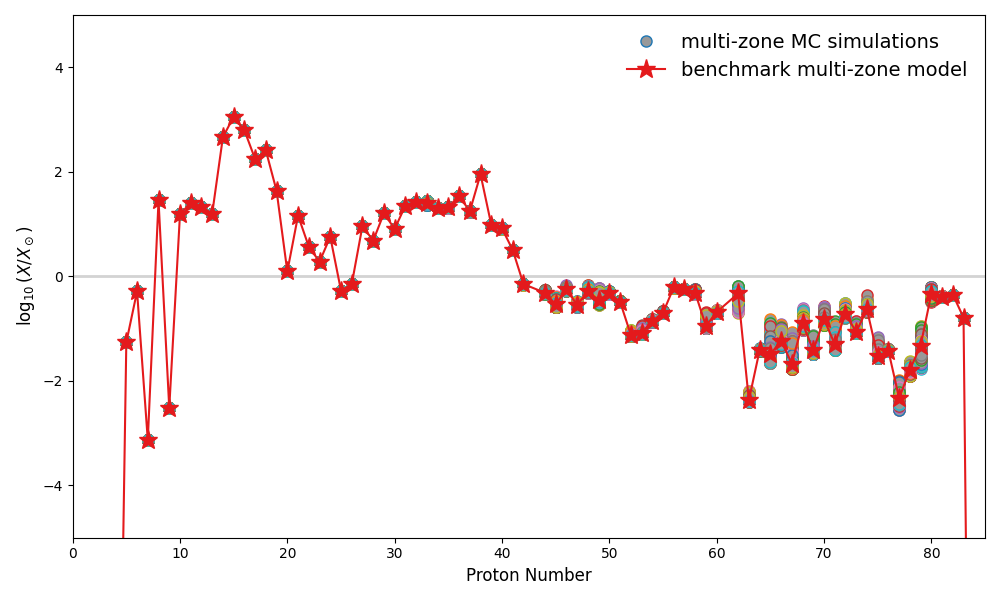

In [10]:
# Initialize figure
ifig=1;plt.close(ifig);
fig, ax = plt.subplots(num=ifig,figsize=(10, 6))

for mc in range(mc_runs):
    z_plot, y_plot, el_name_plot = [], [], []
    
    for i in range(n_el):  
        if i not in {0, 43, 61}:  # Skip elements with negligible solar abundance
            z_plot.append(z_el[i])
            y_value = -20.
            if el_abu_sol[i] > 1e-30 and el_abu_0[i] > 1e-30:
                y_value = np.log10(el_abu[mc, i] / el_abu_sol[i])
                if i == 3:
                    y_value = np.log10((el_abu[mc, i] + el_abu[mc, i+1]) / el_abu_sol[i])  # Li = Li+Be
            y_plot.append(y_value)
            el_name_plot.append(el_name[i])
    
    plt.plot(z_plot, y_plot, linestyle='None', marker='o', markerfacecolor=CB_color[6], markersize=8, 
             label='multi-zone MC simulations' if mc == 0 else "")

# Benchmark model
z_plot, y_plot, el_name_plot = [], [], []
for i in range(n_el):  
    if i not in {0, 43, 61}:  
        z_plot.append(z_el[i])
        y_value = -20.
        if el_abu_sol[i] > 1e-30 and el_abu_0[i] > 1e-30:
            y_value = np.log10(el_abu_0[i] / el_abu_sol[i])
            if i == 3:
                y_value = np.log10((el_abu_0[i] + el_abu_0[i+1]) / el_abu_sol[i])  # Li = Li+Be
        y_plot.append(y_value)
        el_name_plot.append(el_name[i])

plt.plot(z_plot, y_plot, color=CB_color[7], marker='*', markerfacecolor=CB_color[7], markersize=14,
         label='benchmark multi-zone model')

# Formatting
plt.ylim(-5, 5)
plt.xlim(0, n_el)
plt.xlabel('Proton Number', fontsize='large')
plt.ylabel('$\log_{10}\,(X/X_\odot)$', fontsize='large')
plt.legend(numpoints=1, fontsize=14, frameon=False, loc='upper right')
plt.hlines(0, 0, n_el, color='lightgray', lw=2)
plt.tight_layout()


# Version that is a highlight to show "nuclear imapct" and "nuclear impact + convection impact"

## Pearson correlation coefficients

In [11]:
pnuclei = ['Se-74', 'Kr-78', 'Sr-84', 'Mo-92', 'Mo-94', 'Ru-96', 'Ru-98', 'Pd-102', 'Cd-106', 'Cd-108',
           'In-113', 'Sn-112', 'Sn-114', 'Sn-115', 'Te-120', 'Xe-124', 'Xe-126', 'Ba-130', 'Ba-132',
           'La-138', 'Ce-136', 'Ce-138', 'Sm-144', 'Gd-152', 'Dy-156', 'Dy-158', 'Er-162', 'Er-164', 'Yb-168', 'Hf-174', 
           'Ta-180', 'W-180', 'Os-184', 'Pt-190', 'Hg-196']

#### Isotopes


Isotope Index: 584 Isotope Name: Mo-92
549 Zr-90 0.1556 
569 Nb-93 -0.9372 
585 Mo-93 -0.8190 
586 Mo-94 -0.9109 
587 Mo-95 -0.4440 
588 Mo-96 -0.2660 
625 Ru-100 -0.1744 
715 Cd-110 -0.2040 
716 Cd-111 -0.1641 


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Isotope Index: 586 Isotope Name: Mo-94
569 Nb-93 0.9850 
584 Mo-92 -0.9109 
585 Mo-93 0.8696 
587 Mo-95 0.4786 
588 Mo-96 0.3036 

Isotope Index: 621 Isotope Name: Ru-96
589 Mo-97 -0.6998 
605 Tc-97 -0.6999 
623 Ru-98 -0.4358 


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Isotope Index: 623 Isotope Name: Ru-98
589 Mo-97 0.3236 
605 Tc-97 0.3236 
621 Ru-96 -0.4358 


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


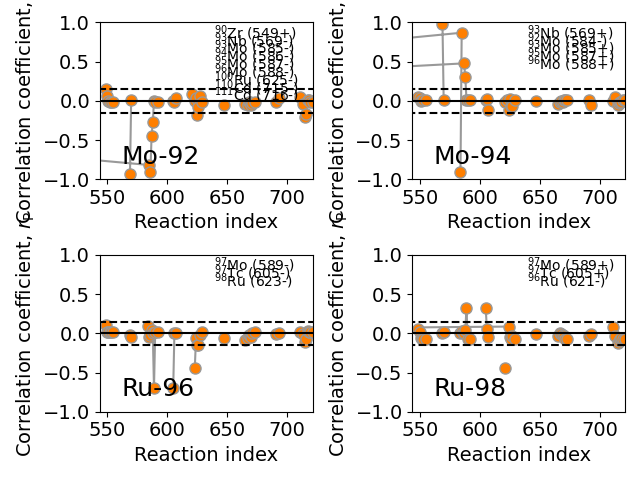

In [12]:
# Define the isotopes you want to analyze
isotope_list = ['Mo-92', 'Mo-94', 'Ru-96', 'Ru-98']

# Create a full list of isotope names in the format 'Element-MassNumber'
iso_full_name = [iso_name[i] + '-' + str(int(iso_a[i])) for i in range(n_iso)]

# Initialize the plot
ifig = ifig + 1
plt.close(ifig)
fig = plt.figure(ifig)
size = 10
fig.canvas.layout.height = str(0.9 * size) + 'in'   # Adjust figure height
fig.canvas.layout.width = str(1.1 * size) + 'in'    # Adjust figure width

iso_name_plot = ["    " for x in range(n_iso)]
i_sub = 0
kmin = []
rmin = 0.15  # Minimum value for the correlation coefficient


for isotope in isotope_list:
    # Find the index of the current isotope
    try:
        i = iso_full_name.index(isotope)
    except ValueError:
        print(f"Isotope {isotope} not found in the data.")
        continue

    k_plot = -1
    i_sub += 1

    # Calculate the abundance ratio for the isotope
    y = iso_abu[:, i] / iso_abu_0[i]

    print("\nIsotope Index:", i, "Isotope Name:", iso_full_name[i])

    x_plot = np.zeros(n_iso)
    y_plot = np.zeros(n_iso)

    for k in range(n_iso):
        
        if k == i: continue 
        
        x = iso_abu[:, k]
        r = stats.pearsonr(x, y)
        x_plot[k] = k
        y_plot[k] = r[0]

        if np.abs(y_plot[k]) >= rmin:
            sign = '+' if r[0] >= 0 else '-'
            kmin.append(k)
            k_plot += 1
            
            this_name = iso_name[k] + '-' + str(int(iso_a[k]))
            
            iso_name_plot[k_plot] = f'$^{{{round(iso_a[k])}}}${iso_name[k]} ({k}{sign})'

            print(f"{k} {this_name} {r[0]:.4f} ")
            
    # Plotting
    plt.subplot(2, 2, i_sub)
    plt.plot(x_plot, y_plot, color=CB_color[6], marker='o', markerfacecolor=CB_color[1], markersize=8)
    plt.xlim(min(kmin) - 5, max(kmin) + 5)
    plt.ylim(-1, 1)
    plt.xlabel('Reaction index', fontsize=14)
    plt.ylabel('Correlation coefficient, $r_{\\mathrm{P}}$', fontsize=14)
    plt.text(min(kmin) - 4 + 0.1 * (max(kmin) - min(kmin)), -0.8, iso_full_name[i], fontsize=18)

    if k_plot > -1:
        for kk in range(k_plot + 1):
            plt.text(max(kmin) + 2.5 - 0.475 * (max(kmin) - min(kmin)), 0.7 - (kk - 1) * 0.1,
                     iso_name_plot[kk], fontsize=10)

    # Add threshold lines
    plt.plot([-0.5, n_iso - 0.5], [rmin, rmin], 'k--')
    plt.plot([-0.5, n_iso - 0.5], [-rmin, -rmin], 'k--')
    plt.plot([-0.5, n_iso - 0.5], [0, 0], 'k-')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


#### Reactions


Isotope Index: 966 Isotope Name: Ce-136
285 ND 138 (g,n) -0.3786 
947 ND 138 (g,p) 0.6486 
1609 ND 138 (g,a) -0.1649 
1611 ND 140 (g,a) 0.3388 

Isotope Index: 968 Isotope Name: Ce-138
261 CE 137 (g,n) 0.5077 
262 CE 139 (g,n) -0.4305 
285 ND 138 (g,n) -0.2954 
936 PR 139 (g,p) 0.2874 
1609 ND 138 (g,a) -0.2195 

Isotope Index: 1164 Isotope Name: Dy-156
406 ER 159 (g,n) -0.1806 
641 PB 202 (g,n) 0.1765 
1731 ER 160 (g,a) 0.7371 

Isotope Index: 1166 Isotope Name: Dy-158
635 PB 196 (g,n) 0.1646 
641 PB 202 (g,n) 0.1832 
1729 ER 158 (g,a) -0.2348 
1731 ER 160 (g,a) 0.5624 


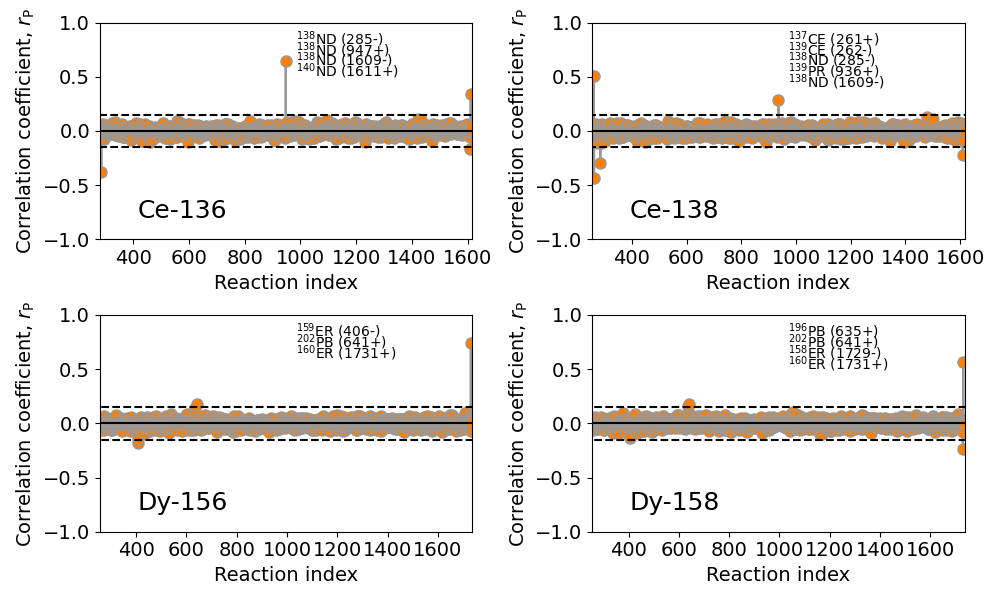

In [ ]:
ifig=2;plt.close(ifig);plt.figure(ifig, figsize=(10,6))

# Define the isotopes you want to analyze
isotope_list = pnuclei

# Create a full list of isotope names in the format 'Element-MassNumber'
iso_full_name = [iso_name[i] + '-' + str(int(iso_a[i])) for i in range(n_iso)]

iso_name_plot = ["    " for x in range(n_fac)]
i_sub = 0
kmin = []
rmin = 0.15  # Minimum value for the correlation coefficient

# Loop over the isotopes in your list
for isotope in ["Ce-136", "Ce-138", "Dy-156", "Dy-158"]:
    # Find the index of the current isotope
    try:
        i = iso_full_name.index(isotope)
    except ValueError:
        print(f"Isotope {isotope} not found in the data.")
        continue

    k_plot = -1
    i_sub += 1

    # Calculate the abundance ratio for the isotope
    y = iso_abu[:, i] / iso_abu_0[i]

    print("\nIsotope Index:", i, "Isotope Name:", iso_full_name[i])

    x_plot = np.zeros(n_fac)
    y_plot = np.zeros(n_fac)

    for k in range(n_fac):
        x = mc_fac[:, k]
        r = stats.pearsonr(x, y)
        x_plot[k] = k
        y_plot[k] = r[0]

        if np.abs(y_plot[k]) >= rmin:
            sign = '+' if r[0] >= 0 else '-'
            kmin.append(k)
            k_plot += 1
            iso_name_plot[k_plot] = f'$^{{{mass[k]}}}${name[k]} ({k}{sign})'

            print(f"{k} {name[k]} {mass[k]} {rtypes[k]} {r[0]:.4f} ")

    # Plotting
    plt.subplot(2, 2, i_sub)
    plt.plot(x_plot, y_plot, color=CB_color[6], marker='o', markerfacecolor=CB_color[1], markersize=8)
    plt.xlim(min(kmin) - 5, max(kmin) + 5)
    plt.ylim(-1, 1)
    plt.xlabel('Reaction index', fontsize=14)
    plt.ylabel('Correlation coefficient, $r_{\\mathrm{P}}$', fontsize=14)
    plt.text(min(kmin) - 4 + 0.1 * (max(kmin) - min(kmin)), -0.8, iso_full_name[i], fontsize=18)

    if k_plot > -1:
        for kk in range(k_plot + 1):
            plt.text(max(kmin) + 2.5 - 0.475 * (max(kmin) - min(kmin)), 0.7 - (kk - 1) * 0.1,
                     iso_name_plot[kk], fontsize=10)

    # Add threshold lines
    plt.plot([-0.5, n_fac - 0.5], [rmin, rmin], 'k--')
    plt.plot([-0.5, n_fac - 0.5], [-rmin, -rmin], 'k--')
    plt.plot([-0.5, n_fac - 0.5], [0, 0], 'k-')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()

#### Plot the histogram

The mean spread is 0.56


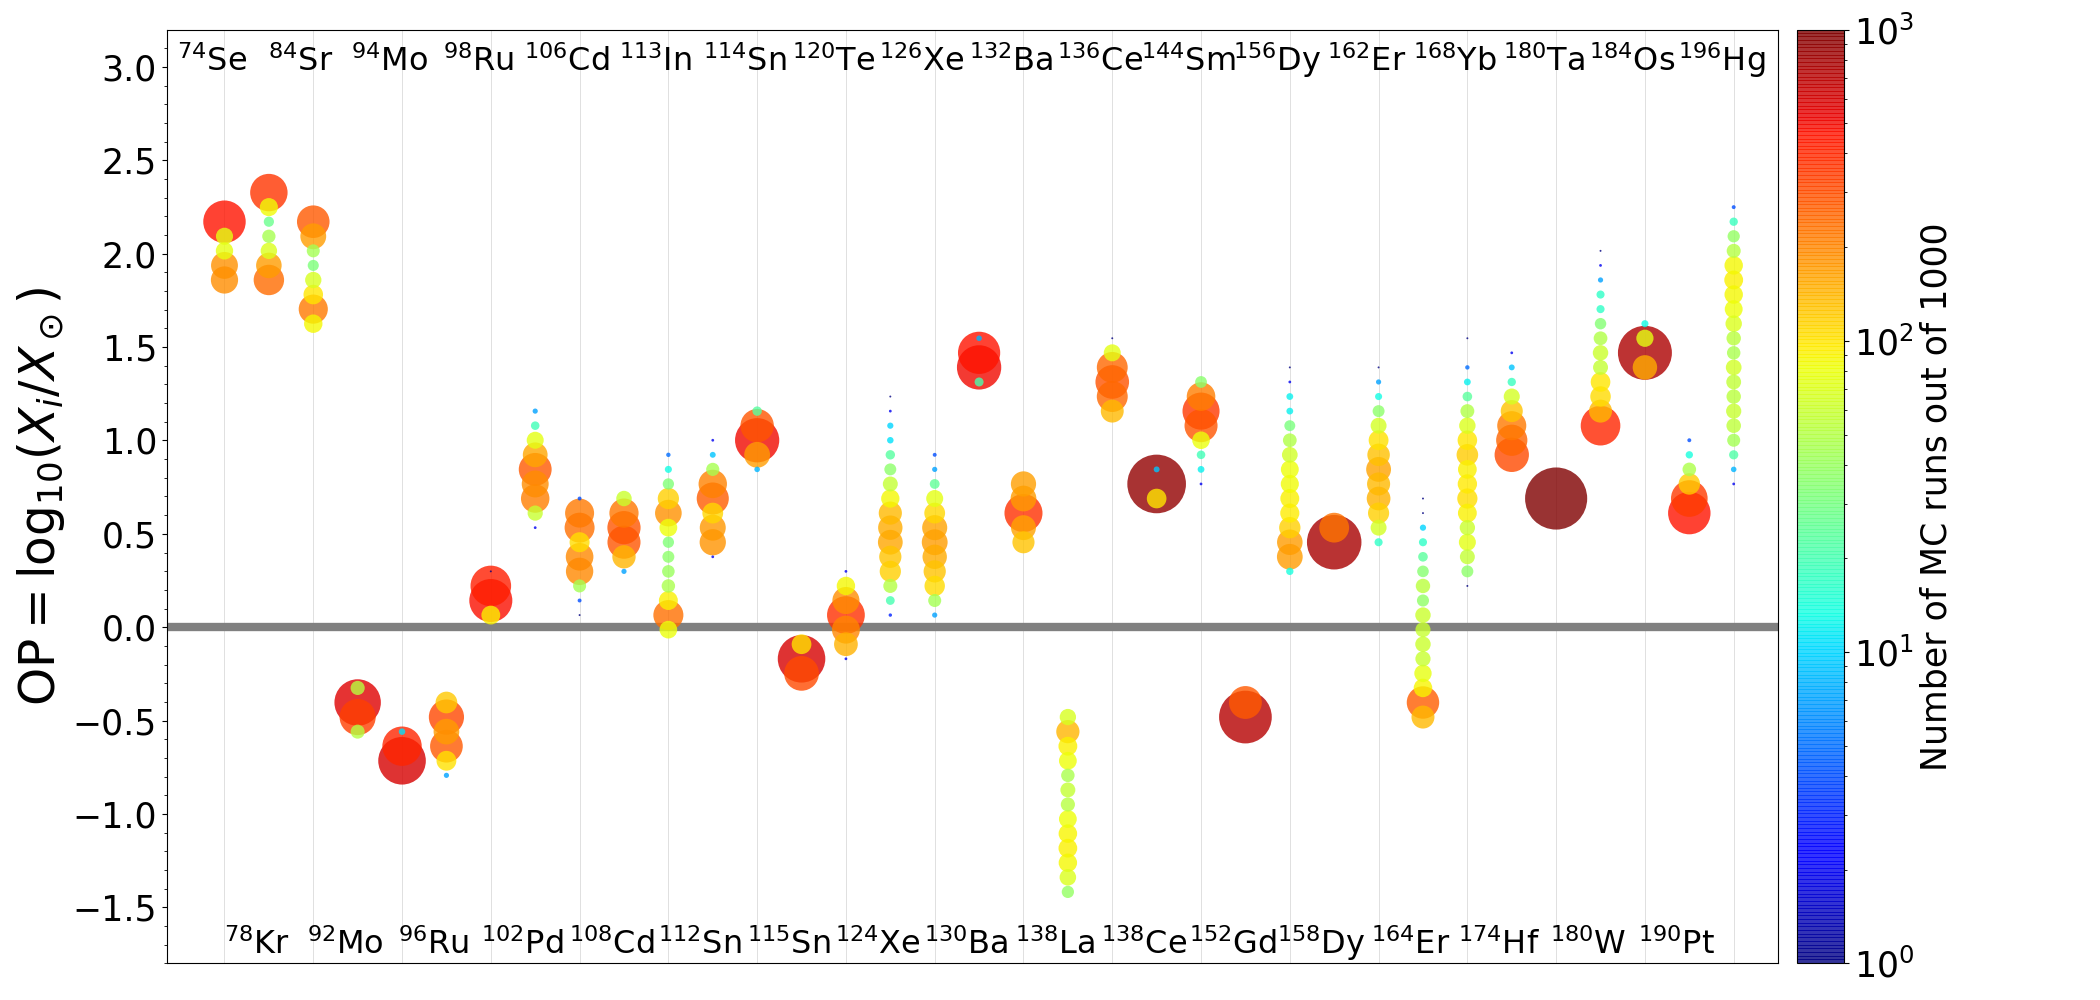

In [18]:
# Define the isotopes you want to plot

# Create a full list of isotope names in the format 'Element-MassNumber'
iso_full_name = [f"{iso_name[i]}-{int(iso_a[i])}" for i in range(n_iso)]

# Initialize the figure
ifig = 9
plt.close(ifig)
fig = plt.figure(ifig, figsize=(21, 10))  # Adjust figure size as needed

# Initialize arrays for plotting template abundances
x0 = []
y0 = []
ii = 0  # Counter for valid isotopes

# Determine the global min and max for the logarithmic abundance ratio to set consistent binning
log_ratios_all = []

for isotope in pnuclei:
    try:
        i = iso_full_name.index(isotope)
    except ValueError:
        print(f"Isotope {isotope} not found in the data.")
        continue

    # Calculate the logarithm of the abundance ratio
    numerator = iso_abu[:, i]
    denominator = get_sol_abu(isotope)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where(denominator != 0, numerator / denominator, np.nan)
        yh = np.log10(ratio)
    yh = yh[np.isfinite(yh)]  # Remove infinities and NaNs

    if len(yh) == 0:
        continue
    
    # Append to global list for calculating the common bin edges
    log_ratios_all.extend(yh)

# Define consistent bins based on the global range of log-abundance ratios
log_min = np.min(log_ratios_all) #1
log_max = np.max(log_ratios_all) #1000

common_bins = np.linspace(log_min, log_max, 50)


norm = mpl.colors.LogNorm(vmin=1, vmax=1000)
# Plot each isotope using the common bins
spread = []
for isotope in pnuclei:
    try:
        i = iso_full_name.index(isotope)
    except ValueError:
        print(f"Isotope {isotope} not found in the data.")
        continue

    numerator = iso_abu[:, i]
    denominator = get_sol_abu(isotope)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where(denominator != 0, numerator / denominator, np.nan)
        yh = np.log10(ratio)
    yh = yh[np.isfinite(yh)]  # Remove infinities and NaNs

    spread.append( np.max(yh) - np.min(yh) )

    if len(yh) == 0:
        continue
    
    # Create a histogram using the common bins
    n, _ = np.histogram(yh, bins=common_bins)
    area = n / 0.5  # Adjust as needed
    
    nn = len(n)
    x = np.full(nn, ii)  # Use ii to position isotopes along the x-axis
    y = 0.5 * (common_bins[:-1] + common_bins[1:])

    sorted_indices = np.argsort(area)[::-1]
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    area_sorted = area[sorted_indices]
    n_sorted = n[sorted_indices]
    
    # Plot the scatter points
    plt.scatter(x_sorted, y_sorted, marker='o', s=area_sorted, c=n_sorted, alpha=0.8, edgecolors='none', cmap='jet', norm=norm,zorder=5)

    # Store the isotope index and template abundance for plotting
    x0.append(ii)
    y0.append(0)  # Since log10(1) = 0
    ii += 1

# Add colorbar to the plot
cbar = plt.colorbar(pad=0.01)
cbar.set_label('Number of MC runs out of 1000', fontsize=25)
cbar.ax.tick_params(labelsize=25)

# Adjust plot limits and labels
plt.xlim(-1.3, ii)
plt.ylim(-1.8, 3.2)
#plt.xlabel('Isotope Index')
plt.ylabel(r'$\mathrm{OP}=\log_{10}(X_i/X_\odot)$', fontsize=35)
plt.yticks(np.arange(-1.5,3.1,0.5), fontsize=25)
plt.minorticks_on()
plt.xticks([])

ymin, ymax = -1.75, 3.05

# Add isotope labels
yshift = 0.1
for idx, isotope in enumerate(pnuclei, 1):
    
    ele, A = isotope.split('-')
    iso = fr'$^{{{A}}}\mathrm{{{ele}}}$'
    
    text_y = 3.08-yshift if idx % 2 == 1 else -1.85+yshift
    if idx%2==1: plt.axvline(idx-1, color='lightgrey', lw=0.5,zorder=1)
    plt.text(idx-1.28, text_y, iso, ha='center', fontsize=23)
            
plt.axhline(0, color='grey', lw=6, zorder=2)
"""
if mixing_case.startswith("PPM") and mixing_case != 'PPM': 
    fronthalf = mixing_case[3:]
    mixing_case_title = fr'${{{fronthalf}}}\times$' + '3D-insp.'
else:
    mixing_case_title = mixing_case.replace('PPM', '3D-insp.')

plt.title('Mixing Case '+ mixing_case_title)
"""
plt.tight_layout()

#print(spread)
print(f'The mean spread is {round(np.mean(spread),2)}')

#plt.savefig('nuclearimpact_MLT.pdf', dpi=300, bbox_inches='tight')

In [38]:
mc_runs, el_name, z_el, n_el, el_abu_0, el_abu, el_abu_sol, n_fac, n_iso, iso_name, iso_a, iso_abu, iso_abu_0, mc_fac, name, mass, rtypes, varmax = get_everything_you_need("MLT")

This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files

n_init = 83
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files

n_sol = 83
X_sol = 0.706457139998516 , X_sol(Tc) = 1e-99 , X_sol(Pm) = 1e-99
Zero variation case: /scratch/f/fherwig/jissa/multizone_MC_RUNS/multi-zone_RAWD_MC_sims_cedar/MLT_MC_results/MLT_MC_0_OC.0010001.surf.h5
Number of Elements:

#### Plot the correlation to get a slope


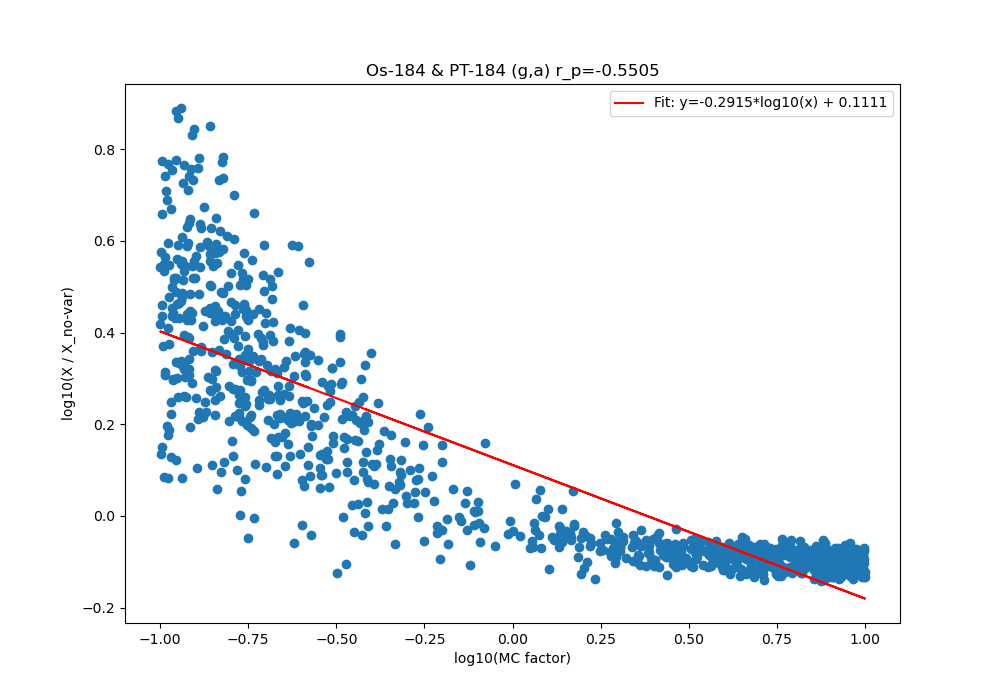

In [26]:
ifig=12;plt.close(ifig);plt.figure(ifig, figsize=(10,7))


isotope = 'Os-184'

k = 1889

try:
    i = iso_full_name.index(isotope)
except ValueError:
    print(f"Isotope {isotope} not found in the data.")

y = iso_abu[:, i] / iso_abu_0[i]
x = mc_fac[:, k]

r = stats.pearsonr(x, y)

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(x), np.log10(y))
x_fit = np.log10(x)
y_fit = slope * x_fit + intercept
plt.scatter(np.log10(x),np.log10(y))
plt.plot(x_fit, y_fit, color='red', label=f'Fit: y={slope:.4f}*log10(x) + {intercept:.4f}')

plt.ylabel('log10(X / X_no-var)')
plt.xlabel('log10(MC factor)')

plt.title(f'{isotope} & {name[k]}-{mass[k]} {rtypes[k]} r_p={r[0]:.4f}')

plt.legend()

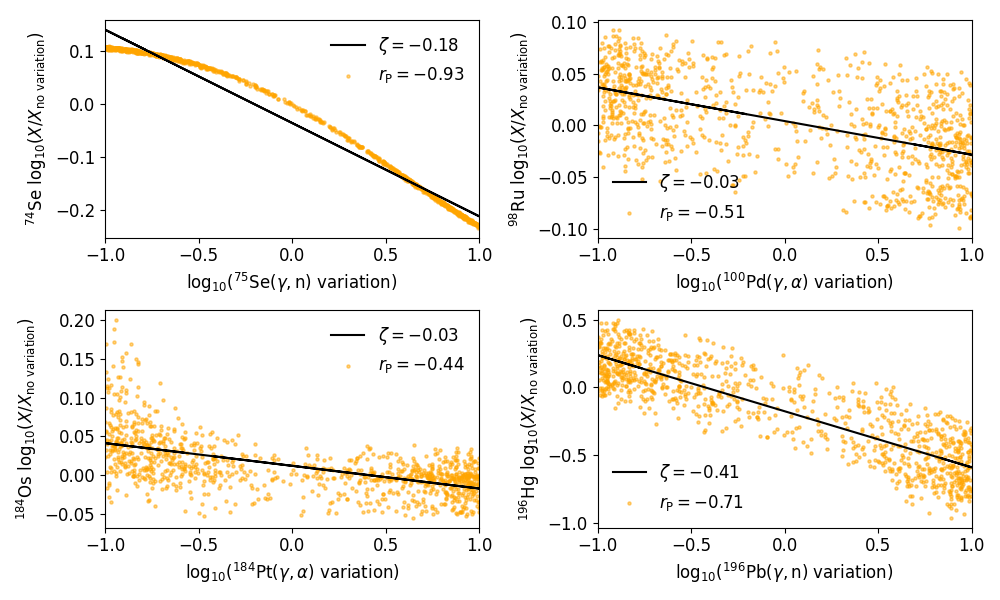

In [35]:
def plot_correlation(ax, isotope, k):
    try:
        i = iso_full_name.index(isotope)
    except ValueError:
        print(f"Isotope {isotope} not found in the data.")
        return
    
    y = iso_abu[:, i] / iso_abu_0[i]
    x = mc_fac[:, k]

    r = stats.pearsonr(x, y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(x), np.log10(y))

    x_fit = np.log10(x)
    y_fit = slope * x_fit + intercept

    rp_text = r"$r_\mathrm{P}$"
    ax.scatter(np.log10(x), np.log10(y), s=5, label=rf'{rp_text}$={{{r[0]:.2f}}}$', rasterized=True, color='orange', alpha=0.5)
    if intercept > 0:
        #ax.plot(x_fit, y_fit, color='red', label=f'Fit: y={slope:.4f}*log10(x) + {intercept:.4f}')
        ax.plot(x_fit, y_fit, color='black', label=rf'$\zeta={{{slope:.2f}}}$')
    else:
        #ax.plot(x_fit, y_fit, color='red', label=f'Fit: y={slope:.4f}*log10(x) - {np.abs(intercept):.4f}')
        ax.plot(x_fit, y_fit, color='black', label=rf'$\zeta={{{slope:.2f}}}$')
    

    ele, A = isotope.split('-')
    rewrote_isotope = rf'$^{{{A}}}\mathrm{{{ele}}}$'

    ele2 = name[k][0] + name[k][1:].lower()
    rewrote_isotope2 = rf'$^{{{mass[k]}}}\mathrm{{{ele2}}}$'

    react = rf"${{{rtypes[k]}}}$".replace('p', '_PROTON_PLACEHOLDER_')
    react = react.replace('a', r'\alpha').replace('g', r'\gamma').replace('n', r'\mathrm{n}')
    react = react.replace('_PROTON_PLACEHOLDER_', r'\mathrm{p}')

    ax.set_ylabel(rewrote_isotope+r' $\log_{10}(X/X_{\mathrm{no~variation}})$', fontsize=12)
    ax.set_xlabel(r'$\log_{10}$(' + rewrote_isotope2 + react + ' variation)', fontsize=12)

    ax.set_xlim(-1,1)
    #ax.set_title(f'[{rewrote_isotope} | {rewrote_isotope2}{react}]',fontsize=25)
    ax.legend(frameon=False, fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

ifig = 13
plt.close(ifig)
fig, axes = plt.subplots(2, 2, figsize=(10,6))
axes = axes.flatten()

isotopes = ['Se-74', 'Ru-98', 'Os-184', 'Hg-196']
ks = [6, 1435, 1889, 635]

for ax, isotope, k in zip(axes, isotopes, ks):
    plot_correlation(ax, isotope, k)

plt.tight_layout()
plt.savefig('correlation_example.pdf',dpi=300)

#### Write out correlations and slope

In [27]:
output_file = mixing_case+"_correlated_rates.txt"

with open(output_file, "w") as f:
    
    f.write(f"idx ele A rtype r_p slope\n")
    f.write('--------------------------\n')
    for isotope in pnuclei:
        print(isotope)
        try:
            i = iso_full_name.index(isotope)
        except ValueError:
            f.write(f"Isotope {isotope} not found in the data.\n")
            continue

        y = iso_abu[:, i] / iso_abu_0[i]

        f.write(f"\nIsotope Index: {i} Isotope Name: {iso_full_name[i]}\n")

        for k in range(n_fac):
            x = mc_fac[:, k]
            r = stats.pearsonr(x, y)
            slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(x), np.log10(y))

            if np.abs(r[0]) >= rmin: f.write(f"{k} {name[k]} {mass[k]} {rtypes[k]} {r[0]:.4f} {slope:.4f}\n")

    f.write("\n")
    
print(f"Output written to {output_file}")

Se-74
Kr-78
Sr-84
Mo-92
Mo-94
Ru-96
Ru-98
Pd-102
Cd-106
Cd-108
In-113
Sn-112
Sn-114
Sn-115
Te-120
Xe-124
Xe-126
Ba-130
Ba-132
La-138
Ce-136
Ce-138
Sm-144
Gd-152
Dy-156
Dy-158
Er-162
Er-164
Yb-168
Hf-174
Ta-180
W-180
Os-184
Pt-190
Hg-196
Output written to PPM50_correlated_rates.txt


In [30]:
def txt_to_latex_table(file_path,start=None,stop=None):
    # Read the file and parse data
    data = []
    pass_start, pass_stop = False, False
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()

            if parts == []: continue


            if parts[0] == 'Isotope':
                isotope = parts[-1]
                
                
                if not pass_start:
                    if start == None: pass_start = True
                    else:
                        if isotope == start: pass_start = True
                            
                if pass_stop: break
                    
                        
            elif parts[0] == 'idx':
                continue

            elif len(parts) == 6:
                
                #boring = False

                if len(parts[1]) == 2:
                    fp = parts[1][0] + parts[1][1].lower()
                elif len(parts[1]) == 1:
                    fp = parts[1]
                    
                ele, A = isotope.split('-')
                iso = fr"^{{{A}}}"+fr"\mathrm{{{ele}}}"        
                                    
                react = parts[3].replace('p', '_PROTON_PLACEHOLDER_')
                react = react.replace('a', r'\alpha').replace('g', r'\gamma').replace('n', r'\mathrm{n}')
                react =  react.replace('_PROTON_PLACEHOLDER_', r'\mathrm{p}')
                
                reaction = fr"^{{{parts[2]}}}"+ fr"\mathrm{{{fp}}}" +  react
                
                
                rp = parts[4]
                zeta = parts[5]

                                
                if stop == None: pass
                else:
                    if isotope == stop: pass_stop = True 

                        
                # boring filter (cut out adjacent (g,n) stuff)
                #if ele == fp and parts[3] == '(g,n)':
                #    if int(A) - 1 == int(parts[2]): boring = True
                #   if int(A) + 1 == int(parts[2]): boring = True        
                
                        
                if pass_start:# and not boring:
                    data.append([iso, reaction, float(rp), float(zeta)])
            
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["Isotope", "Reaction", "r_P", "ζ"])
    
    # Generate LaTeX table
    latex_table = """\\begin{table}[h]\n\\centering\n\\begin{tabular}{llcc}\n\hline\n\\textbf{Isotope} & \\textbf{Reaction} & $r_\mathrm{P}$ & $\zeta$ \\\\ \hline
    """
    
    latex_table = """\\begin{deluxetable*}{llcc}\n\\tabletypesize{\\scriptsize}\n\\tablewidth{0pt}\n\\tablecaption{FILLER\n\\label{tab:FILLER}}\n\\tablehead{\n\colhead{\\textbf{Isotope}} & \colhead{\\textbf{Reaction}} & \colhead{$r_\mathrm{P}$} & \colhead{$\zeta$}\n}\n\startdata\n"""

    
    
    last_isotope = None
    for _, row in df.iterrows():
        isotope = row["Isotope"]
        reaction = row["Reaction"]
        rp = row["r_P"]
        zeta = row["ζ"]
        
        if isotope == last_isotope:
            latex_table += f" & ${reaction}$ & {rp:.4f} & {zeta:.4f}\\\ \n"
        elif last_isotope != None:
            latex_table += f"${isotope}$ & ${reaction}$ & {rp:.4f} & {zeta:.4f} \\\ \n"
        else:
            latex_table += f"${isotope}$ & ${reaction}$ & {rp:.4f} & {zeta:.4f} \\\ \n"
            
        last_isotope = isotope
    
    latex_table += "\enddata\n\\tablecomments{This is the table comments.}\n\end{deluxetable*}"
    
    return latex_table

# Example usage

mixing_case_read_in = "PPM50" #mixing_case
file_path = mixing_case_read_in+"_correlated_rates.txt"
latex_code = txt_to_latex_table(file_path, start='Ba-132')
print()
print(latex_code)
print()


\begin{deluxetable*}{llcc}
\tabletypesize{\scriptsize}
\tablewidth{0pt}
\tablecaption{FILLER
\label{tab:FILLER}}
\tablehead{
\colhead{\textbf{Isotope}} & \colhead{\textbf{Reaction}} & \colhead{$r_\mathrm{P}$} & \colhead{$\zeta$}
}
\startdata
$^{132}\mathrm{Ba}$ & $^{132}\mathrm{Ce}(\gamma,\mathrm{n})$ & -0.2763 & -0.0392 \\ 
 & $^{133}\mathrm{Ce}(\gamma,\mathrm{n})$ & -0.1933 & -0.0269\\ 
 & $^{132}\mathrm{Ce}(\gamma,\mathrm{p})$ & -0.2505 & -0.0328\\ 
 & $^{132}\mathrm{Ce}(\gamma,\alpha)$ & -0.3079 & -0.0427\\ 
 & $^{134}\mathrm{Ce}(\gamma,\alpha)$ & -0.1822 & -0.0232\\ 
$^{138}\mathrm{La}$ & $^{137}\mathrm{La}(\gamma,\mathrm{n})$ & -0.7482 & -0.4462 \\ 
$^{136}\mathrm{Ce}$ & $^{138}\mathrm{Nd}(\gamma,\mathrm{n})$ & -0.4242 & -0.0938 \\ 
 & $^{138}\mathrm{Nd}(\gamma,\mathrm{p})$ & 0.6632 & 0.1415\\ 
 & $^{140}\mathrm{Nd}(\gamma,\alpha)$ & 0.2518 & 0.0553\\ 
$^{138}\mathrm{Ce}$ & $^{138}\mathrm{Nd}(\gamma,\mathrm{n})$ & -0.3300 & -0.0413 \\ 
 & $^{139}\mathrm{Nd}(\gamma,\mathrm{n})$ &

In [ ]:
file_path = "MLT_correlated_rates.txt"

isotopes = []
rates = []
reactions = []

with open(file_path, "r") as file:
    for line in file:
        if "Isotope Name:" in line:
            current_isotope = line.split(":")[-1].strip()
        elif "(g,p)" in line:  
            parts = line.split()
            rate = float(parts[-2])
            
            if len(parts[1]) == 2: parts[1] = parts[1][0] + parts[1][1].lower()
            
            reaction =  fr"$^{{{parts[2]}}}$" + parts[1] + parts[3]  # Element + Reaction Type
                        
            isotopes.append(current_isotope)
            rates.append(rate)
            reactions.append(reaction)

plt.figure(figsize=(12, 6))
plt.scatter(isotopes, rates, color="blue", alpha=0.7)

for isotope, rate, reaction in zip(isotopes, rates, reactions):
    plt.annotate(reaction, (isotope, rate), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

plt.xticks(rotation=90, fontsize=10)
plt.ylabel("Pearson Correlation")
plt.title("10x3D-insp. Correlations")
plt.grid(True, linestyle="--", alpha=0.5)


## Plot a lognormal distribution of the mass fraction 

for which

$\log_{10}\mu (X) = \mu (\log_{10}X) + \frac{1}{2}\sigma^2(\log_{10}X)$.

MLT : Hg-196 is bifurcated; Sm-144 is maybe (?); Dy-156 is maybe (?)

In [ ]:
ifig = 100; close(ifig); figure(ifig, figsize=(10, 8))

# Define the isotope to plot
isotope = "Cd-108"  # Replace with the isotope you're interested in

# Find the index of the specific isotope in the full list
try:
    i = iso_full_name.index(isotope)
except ValueError:
    print(f"Isotope {isotope} not found in the data.")
    raise

# Calculate log-ratio abundance for the specific isotope
numerator = iso_abu[:, i]
denominator = get_sol_abu(isotope)
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = np.where(denominator != 0, numerator / denominator, np.nan)
    yh = np.log10(ratio)
yh = yh[np.isfinite(yh)]  # Remove infinities and NaNs

if len(yh) == 0:
    print(f"No valid data found for isotope {isotope}.")
else:
    # Calculate the mean and standard deviation of the log-ratio abundances
    mu_log = np.mean(yh)
    sigma_log = np.std(yh)

    # Define the range for plotting the lognormal distribution
    x_vals = np.linspace(np.min(yh), np.max(yh), 1000)

    # Calculate the lognormal PDF with the calculated mean and standard deviation
    pdf_vals = lognorm.pdf(x_vals, sigma_log, scale=np.exp(mu_log))

    # Plot the lognormal distribution
    #plt.plot(x_vals, pdf_vals, label=f'Lognormal fit: $\mu = {mu_log:.2f}$, $\sigma = {sigma_log:.2f}$')

    # Plot the data points (histogram for the isotope's log-ratio abundance)
    plt.hist(yh, bins=50, density=True, alpha=0.5, facecolor='g', lw=2, edgecolor='black')

    # Add labels, title, and other plot elements
    plt.xlabel('$\log_{10}(X/X_{\odot})$', fontsize=14)
    plt.ylabel('Probability Density', fontsize=14)
    plt.title(f'Lognormal Distribution Fit to {isotope} Abundance Ratios', fontsize=16)
    plt.tight_layout()


### If the above distribution is double-peaked, find out which isotope cases the bifurcation

In [ ]:
ifig=101;close(ifig);figure(ifig)

### ADAPT TO MAKE IT ABOUT ISOTOPES

isotope = 'Te-120' # 'La'

i = iso_full_name.index(isotope)

yh = np.linspace(0,0,mc_runs)
imc = -1
yh2 = np.linspace(0,0,mc_runs)
imc2 = -1

# select an isotope on which i process path is likely to bifurcate
reaction = 'PB-196' # 'BA-139' # 'NI-66'
ibif = 181
facbif = 1.0  # the reaction rate factor for bifurcation

for mc in range(mc_runs):
    if mc_fac[mc][ibif] >= facbif:  # this is the reaction that bifurcates the n-capture path
        imc += 1
        yh[imc] = log10(iso_abu[mc,i]/get_sol_abu(isotope))
    else:
        imc2 += 1
        yh2[imc2] = log10(iso_abu[mc,i]/get_sol_abu(isotope))

x_template = log10(iso_abu_0[i]/get_sol_abu(isotope))


bins = 50

# the histogram of the data
n, mybins, patches = plt.hist(yh[0:imc], bins, density=0, facecolor=CB_color[0], alpha=0.65)
n2, mybins2, patches2 = plt.hist(yh2[0:imc2], bins, density=0, facecolor=CB_color[8], alpha=0.65)

# best fit of data
#(fit_mu, fit_sigma) = norm.fit(yh[0:imc])
#(fit_mu2, fit_sigma2) = norm.fit(yh2[0:imc2])

# add a 'best fit' line
#y = 250.*norm.pdf(mybins, fit_mu, fit_sigma)
#l = plt.plot(mybins, y, color=CB_color[7], linewidth=2)

#y2 = 230.*norm.pdf(mybins2, fit_mu2, fit_sigma2)
#l2 = plt.plot(mybins2, y2, color=CB_color[7], linewidth=2)

# use the next 7 lines to plot a Gaussian of an observed abundance for given mu and sigma
mu = 2.8
sigma = 0.19
s = np.random.normal(mu, sigma, 1000)
count, obsbins, ignored = plt.hist(s, bins, density=0, facecolor=CB_color[0], alpha=0.0)
ynorm = 0.5*(mc_runs*sigma/np.sqrt(8*np.pi))/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (obsbins - mu)**2 / (2 * sigma**2) )
y3 = np.linspace(0,0,len(ynorm))

xlabel('$\log_{10}\,(X(\mathrm{'+isotope+'})/X_\odot(\mathrm{'+isotope+'}))$')
ylabel('number of MC runs out of 1000')


xmax = max(np.max(yh), np.max(yh2))
xmin = min(np.min(yh), np.min(yh2))

ymax = max(np.max(n),np.max(n2))

#yp = [0.,yhmax]
#xt = [x_template,x_template]
#plot(xt,yp,color='k',linestyle='dashed',linewidth=2)
#ylim(0,yhmax)

plt.xlim(xmin-0.1,xmax+0.1)
plt.ylim(0,ymax*1.1)

#title('bifurcation at '+name[ibif]+' '+str(mass[ibif]))
#text(1.55,0.92*yhmax,'bifurcation of '+element+' abundance at '+name[ibif]+'-'+str(mass[ibif]))

if len(name[ibif]) > 1: elename = name[ibif][0] + name[ibif][1:].lower()
else: elename = name[ibif]
title(f'Bifurcation for {isotope} abundance at {elename}-{mass[ibif]} {rtypes[ibif]}')

In [ ]:
# ifig=101;close(ifig);figure(ifig)

element = 'Sn' # 'La'

i = el_name.index(element)
el_to_plot=utils.get_el_from_z(i)

yh = np.linspace(0,0,mc_runs)
imc = -1
yh2 = np.linspace(0,0,mc_runs)
imc2 = -1

# select an isotope on which i process path is likely to bifurcate
reaction = 'PB-196' # 'BA-139' # 'NI-66'
ibif = 453
facbif = 1.0  # the reaction rate factor for bifurcation

for k in range(n_el):
    if float(k)==z_el[i] and k != 0 and k != 43 and k != 61:
        for mc in range(mc_runs):
            if mc_fac[mc][ibif] >= facbif:  # this is the reaction that bifurcates the n-capture path
                imc += 1
                yh[imc] = log10(el_abu[mc,i]/el_abu_sol[k])
            else:
                imc2 += 1
                yh2[imc2] = log10(el_abu[mc,i]/el_abu_sol[k])
        #yh = np.log10(el_abu[::2,i]/el_abu_sol[k])  # skipping every other element (to reduce the number of MC sims)
        x_template = log10(el_abu_0[i]/el_abu_sol[k])

print (imc,imc2)        

bins = 50

# the histogram of the data
n, mybins, patches = plt.hist(yh[0:imc], bins, density=0, facecolor=CB_color[0], alpha=0.65)
n2, mybins2, patches2 = plt.hist(yh2[0:imc2], bins, density=0, facecolor=CB_color[8], alpha=0.65)

# best fit of data
(fit_mu, fit_sigma) = norm.fit(yh[0:imc])
(fit_mu2, fit_sigma2) = norm.fit(yh2[0:imc2])

# add a 'best fit' line
y = 250.*norm.pdf(mybins, fit_mu, fit_sigma)
#l = plt.plot(mybins, y, color=CB_color[7], linewidth=2)

y2 = 230.*norm.pdf(mybins2, fit_mu2, fit_sigma2)
#l2 = plt.plot(mybins2, y2, color=CB_color[7], linewidth=2)

# use the next 7 lines to plot a Gaussian of an observed abundance for given mu and sigma
mu = 2.8
sigma = 0.19
s = np.random.normal(mu, sigma, 1000)
count, obsbins, ignored = plt.hist(s, bins, density=0, facecolor=CB_color[0], alpha=0.0)
ynorm = 0.5*(mc_runs*sigma/np.sqrt(8*np.pi))/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (obsbins - mu)**2 / (2 * sigma**2) )
y3 = np.linspace(0,0,len(ynorm))

xlabel('$\log_{10}\,(X(\mathrm{'+el_to_plot+'})/X_\odot(\mathrm{'+el_to_plot+'}))$')
ylabel('number of MC runs out of 1000')


yp = [0.,yhmax]
xt = [x_template,x_template]
plot(xt,yp,color='k',linestyle='dashed',linewidth=2)
ylim(0,yhmax)

#title('bifurcation at '+name[ibif]+' '+str(mass[ibif]))
text(1.55,0.92*yhmax,'bifurcation of '+element+' abundance at '+name[ibif]+'-'+str(mass[ibif]))

### If it is necessary, find the isotope that causes the secondary bifurcation

In [ ]:
# the reaction I135(n,g) (mc_fac[:][4]) bifurcates the i process band path
# therefore, we make two histogram plots for the cases when mc_fac[:][4] >= 1.0 and mc_fac[:][4] < 1.0

ifig=ifig+1; close(ifig); figure(ifig)

#i = 56 # charge number of the element to plot
#kbif = 14
#kbif2 = 4 # 15

#i = 58 # charge number of the element to plot
#kbif = 20
#kbif2 = 19

#i = 65 # charge number of the element to plot
#kbif = 87
#kbif2 = 81

# select an element to plot its abundance histogram
element = 'Ca'

i = el_name.index(element)
el_to_plot=utils.get_el_from_z(i)

yh = np.linspace(0,0,mc_runs)
imc = -1
yh2 = np.linspace(0,0,mc_runs)
imc2 = -1
yh21 = np.linspace(0,0,mc_runs)
imc21 = -1
yh22 = np.linspace(0,0,mc_runs)
imc22 = -1

# select two isotopes on which i process path is likely to bifurcate
reaction = 'Pt-184'
kbif = reac_full_name.index(reaction)
reaction = 'Pt-184' 
kbif2 = reac_full_name.index(reaction)
facbif = 1.0  # the reaction rate factor for bifurcation

for k in range(n_el):
    if float(k)==z_el[i] and k != 0 and k != 43 and k != 61:
        for mc in range(mc_runs):
            if mc_fac[mc][kbif] >= 1.0:
                if mc_fac[mc][kbif2] >= 1.0:
                    imc += 1
                    yh[imc] = log10(el_abu[mc,i]/el_abu_sol[k])
                else:
                    imc21 += 1
                    yh21[imc21] = log10(el_abu[mc,i]/el_abu_sol[k])
            else:
                if mc_fac[mc][kbif2] >= 1.0:
                    imc2 += 1
                    yh2[imc2] = log10(el_abu[mc,i]/el_abu_sol[k])
                else:
                    imc22 += 1
                    yh22[imc22] = log10(el_abu[mc,i]/el_abu_sol[k])
        #yh = log10(el_abu[:,i]/el_abu_sol[k])
        #yh = log10(el_abu[::2,i]/el_abu_sol[k])  # skipping every other element (to reduce the number of MC sims)
        x_template = log10(el_abu_0[i]/el_abu_sol[k])
# the histogram of the data
n, mybins, patches = hist(yh[0:imc], bins, density=0, facecolor=CB_color[4], alpha=0.55)
n2, mybins2, patches2 = hist(yh2[0:imc2], bins, density=0, facecolor=CB_color[3], alpha=0.55)
n21, mybins21, patches21 = hist(yh21[0:imc21], bins, density=0, facecolor=CB_color[6], alpha=0.55)
n22, mybins22, patches22 = hist(yh22[0:imc22], bins, density=0, facecolor=CB_color[1], alpha=0.55)

# best fit of data
(fit_mu, fit_sigma) = norm.fit(yh[0:imc])
(fit_mu2, fit_sigma2) = norm.fit(yh2[0:imc2])

# add a 'best fit' line
#y = 100.*normpdf(mybins, fit_mu, fit_sigma)
#l = plot(mybins, y, color=CB_color[7], linewidth=2)

#y2 = 100.*normpdf(mybins2, fit_mu2, fit_sigma2)
#l2 = plot(mybins2, y2, color=CB_color[7], linewidth=2)

xlabel('$\log_{10}\,(X(\mathrm{'+el_to_plot+'})/X_\odot(\mathrm{'+el_to_plot+'}))$')
ylabel('number of MC runs out of 10000')
#title("$\mathrm{Histogram\ of\ "+el_to_plot+"\ abundances}$")
#title("$\mathrm{\ caused\ by}\ f("+"^{"+mass[kbif2]+"}\mathrm{"+name[kbif2]+"})$")


yhmax = float(100*((int(max(n))/100)+1))
yhmax = 500

text(1.05,0.92*yhmax,"$\mathrm{bifurcation\ at\ }^{"+\
      mass[kbif]+"}\mathrm{"+name[kbif]+"}\mathrm{\ and\ }^{"+mass[kbif2]+"}\mathrm{"+name[kbif2]+"}$")

yp = [0.,yhmax]
xt = [x_template,x_template]
plot(xt,yp,color='k',linestyle='dashed',linewidth=2)

#plt.xlim(1.3,2.8)
#plt.xlim(0.8,2.2)
# plt.ylim(0.,yhmax)
# xlim(1.0,2.5)

grid(False)
tight_layout()
show()

#plt.savefig("/Users/dpa/Documents/RAWD_MC_sims_results/Ba_hist3.pdf")

In [ ]:
figure(figsize=(10,6))

dilute =0.0041803

i1=56
i2=73
ni=i2-i1+1

for i in range(i1,i2):
    el_to_plot=utils.get_el_from_z(i)
    #yh = np.log10(el_abu[:,i]/el_abu_sol[i])
    yh = np.log10((dilute*el_abu[:,i]+(1.-dilute)*el_abu_init[i])/el_abu_sol[i])-\
                np.log10((dilute*el_abu[:,26]+(1.-dilute)*el_abu_init[26])/el_abu_sol[26])
    # the histogram of the data
    if i != 43 and i != 61:
        n, mybins, patches = plt.hist(yh, 50, normed=0, facecolor='green', alpha=0)

        area = ((n/3)) 

        nn = len(n)
        x = np.linspace(i,i,nn)
        y = np.linspace(0,0,nn)
        for j in range(nn):
            y[j] = 0.5*(mybins[j]+mybins[j+1])

        plt.scatter(x, y, marker='o', s=area, c=n, alpha=0.55, edgecolor='', cmap='jet')

x0 = np.linspace(0,0,ni)
y0 = np.linspace(-99.,-99.,ni)
ii = 0
for i in range(i1,i2):
    if i != 43:
        x0[ii] = float(i)
        #y0[ii] = np.log10(el_abu_0[i]/el_abu_sol[i])
        y0[ii] = np.log10((dilute*el_abu_0[i]+(1.-dilute)*el_abu_init[i])/el_abu_sol[i])-\
                np.log10((dilute*el_abu_0[26]+(1.-dilute)*el_abu_init[26])/el_abu_sol[26])
        ii += 1
plt.plot(x0,y0,'k*',markersize=12)
    
ax = plt.colorbar()
ax.set_label('number of MC runs out of 10000')
plt.xlim(i1-1,i2)
plt.ylim(0.5,3.5)
#plt.ylim(-0.8,4.4)
plt.xlabel('proton number')
#plt.ylabel('$\log_{10}\,X/X_0$')
plt.ylabel('[X/Fe]')
#plt.minorticks_on()
#plt.hlines(0,0,85)
for i in range(i1,i2):
    if i != 43:
        el_to_plot=utils.get_el_from_z(i)
        if i%2 == 0:
            plt.text(i,3.25,el_to_plot,ha='center')
            #plt.text(i,4.0,el_to_plot,ha='center')
        else:
            plt.text(i,0.75,el_to_plot,ha='center')
            #plt.text(i,-0.4,el_to_plot,ha='center')
            
plt.errorbar(z,xfe,yerr,yerr,'ko',markersize=6)   

#grid()

tight_layout()
plt.show()
#plt.savefig("/Users/dpa/Documents/RAWD_mppnp_MC_results/uncertainties.png")

In [129]:
ifig += 1;fig=figure(ifig)
size=10
fig.canvas.layout.height = str(0.9*size)+'in'   # This is a hack to prevent ipympl
fig.canvas.layout.width  = str(1.1*size)+'in'

k = 4 # 14
yh = np.linspace(0,0,mc_runs)
j = 0
for mc in range(mc_runs):
    if mc_fac[mc,k] >= 1.0:
        j = j+1
        yh[j] = mc_fac[mc,k]

# the histogram of the data
n, bins, patches = plt.hist(yh[1:j], 40, normed=0, facecolor='blue', alpha=0.55)

plt.xlabel("$f("+"^{"+mass[k]+"}\mathrm{"+name[k]+"})\geq 1.0$")
plt.ylabel('N')
#plt.grid(True)
tight_layout()
plt.show()

AttributeError: 'Rectangle' object has no property 'normed'

In [130]:
ifig += 1;fig=figure(ifig)
size=10
fig.canvas.layout.height = str(0.9*size)+'in'   # This is a hack to prevent ipympl
fig.canvas.layout.width  = str(1.1*size)+'in'

k = 10 # 14
yh = np.linspace(0,0,mc_runs)
j = 0
for mc in range(mc_runs):
    if mc_fac[mc,k] <= 1.0:
        j = j+1
        yh[j] = 1./mc_fac[mc,k]

# the histogram of the data
n, bins, patches = plt.hist(yh[1:j], 40, normed=0, facecolor='blue', alpha=0.55)

plt.xlabel("$f("+"^{"+mass[k]+"}\mathrm{"+name[k]+"})\leq 1.0$")
plt.ylabel('N')
#plt.grid(True)
tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: 'Rectangle' object has no property 'normed'

In [131]:
ifig += 1;fig=figure(ifig)
size=10
fig.canvas.layout.height = str(0.9*size)+'in'   # This is a hack to prevent ipympl
fig.canvas.layout.width  = str(1.1*size)+'in'

k = 4 # 14
yh = np.log10(mc_fac[:,k])

# the histogram of the data
n, bins, patches = plt.hist(yh[1:j], 40, normed=0, facecolor='blue', alpha=0.55)

plt.xlabel("$\log_{10}\,f("+"^{"+mass[k]+"}\mathrm{"+name[k]+"})$")
plt.ylabel('N')
#plt.grid(True)
tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: 'Rectangle' object has no property 'normed'

In [132]:
#figure(figsize=(10,8))

ifig += 1;fig=figure(ifig)
size=10
fig.canvas.layout.height = str(0.9*size)+'in'   # This is a hack to prevent ipympl
fig.canvas.layout.width  = str(1.1*size)+'in'   # to adjust horizontal figure size

iso_name_plot=["    " for x in range(n_fac)]

iplot = [56,57,58,59,60,62,63,64,65,66,67,68,69,70,71,72]

i_sub = 0

kmin = []

rmin = 0.15  # the minimum value for the correlation coefficient

#for ip in range(len(iplot)):
for ip in range(0,4):
#for ip in range(4,8):
#for ip in range(8,12):
#for ip in range(12,16):
    i = iplot[ip]
    k_plot = -1
    i_sub += 1
    y = np.log10(el_abu[:,i]/el_abu_0[i])
    #y = (el_abu[:,i]/el_abu_0[i])
    #y = el_abu[:,i]
    #y = np.log10(el_abu[:,i])

    print (i, el_name[i])

    x_plot = np.linspace(0,0,n_fac)
    y_plot = np.linspace(0,0,n_fac)

    for k in range(n_fac):
        x = mc_fac[:,k]
        r = stats.pearsonr(x, y)
        x_plot[k] = k
        y_plot[k] = r[0]
        if np.abs(y_plot[k]) >= rmin:
            sign = '+'
            kmin.append(k)
            if r[0] < 0:
                sign = '-'
            k_plot += 1
            iso_name_plot[k_plot] = '$^{'+mass[k]+'}$'+name[k]+' ('+str(k)+sign+')'               
    
        if np.abs(r[0]) >= rmin:
            print (k, name[k], mass[k], r[0], r[1])
    print ("\n")

    plt.subplot(2,2,i_sub)
    #plt.plot(x_plot,y_plot,'ro')
    plt.plot(x_plot,y_plot,color=CB_color[6],marker='o',markerfacecolor=CB_color[1],markersize=8)
    plt.xlim(min(kmin)-5,max(kmin)+5)
    plt.ylim(-1,1)
    plt.xlabel('Reaction index',fontsize=14)
    plt.ylabel('Correlation coefficient, $r_{\mathrm{P}}$',fontsize=14)
    plt.minorticks_on()
    plt.text(min(kmin)-4.5+0.1*(max(kmin)-min(kmin)),-0.8,el_name[i],fontsize=18)
    if k_plot > -1:
        for kk in range (k_plot+1):
            plt.text(max(kmin)+2.0-0.7*(max(kmin)-min(kmin)),0.65-(kk-1)*0.15,iso_name_plot[kk],fontsize=12)
    
    xx = [-0.5,294.5]
    yy = [rmin,rmin]
    plt.plot(xx,yy,'k--')
    xx = [-0.5,294.5]
    yy = [-rmin,-rmin]
    plt.plot(xx,yy,'k--')
    xx = [-0.5,294.5]
    yy = [0,0]
    plt.plot(xx,yy,'k-')
    
tight_layout()
plt.show()
#plt.savefig("/Users/dpa/Documents/RAWD_mppnp_MC_results/MC_correlations_rmin15_BaLaCePr.png")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

56 Ba
257 CE 132 -0.23570879302607162 4.316406379634146e-14
259 CE 134 -0.20707935735943314 3.7908111609844454e-11
287 ND 140 -0.4901482111002412 1.4676044376899714e-61
1611 ND 140 -0.2601449299551381 6.24120834583882e-17


57 La
285 ND 138 -0.1520242381615736 1.3686755374731715e-06
286 ND 139 -0.3983407450987935 2.2729066265296263e-39
287 ND 140 -0.33073285779141165 5.954199401634389e-27
1611 ND 140 -0.37795223756692287 2.6190959411609336e-35


58 Ce
287 ND 140 -0.6231000139724677 1.2768992541633119e-108
1611 ND 140 -0.31004891707639004 1.0084274370861603e-23


59 Pr
287 ND 140 -0.3937343072760525 1.9923966213579532e-38
320 SM 141 -0.3504040373519225 2.9178493463320983e-30
982 SM 141 -0.3951091557306071 1.0460364773078912e-38
983 SM 142 -0.1886980958305845 1.8122506321408035e-09
1611 ND 140 -0.24917601092582775 1.2827908600345353e-15




In [ ]:
i1 = 17
i2 = 30

rmin = 0.15  # the minimum value for the correlation coefficient

for i in range(i1,i2+1):
#     y = np.log10(el_abu[:,i]/el_abu_0[i])
    y = (el_abu[:,i]/el_abu_0[i])
#     y = el_abu[:,i]
#     y = np.log10(el_abu[:,i])

    print (i, el_name[i])

    for k in range(n_fac):
        x = mc_fac[:,k]
#         x = np.log10(mc_fac[:,k])
        r = stats.pearsonr(x, y)
        if np.abs(r[0]) > rmin:
            print (k, name[k], mass[k], rtypes[k], r[0], r[1])
    print ("\n")

In [ ]:
i1 = 20
i2 = 22

rmin = 0.15

y = el_abu[:,i1]/el_abu[:,i2]

print (el_name[i1], "/", el_name[i2])

for k in range(22):
    x = mc_fac[:,k]
    r = stats.pearsonr(x, y)
    if np.abs(r[0]) > rmin:
        print (k, fac[k][0], fac[k][1], r[0], r[1])

In [ ]:
i = 20 
k = 20 # 
#y = np.log10(el_abu[:,i]/el_abu_0[i])
y = (el_abu[:,i]/el_abu_0[i])
#y = np.log10(el_abu[:,i1]/el_abu[:,i2])
#y = el_abu[:,i]
#y = np.log10(el_abu[:,i])
#x = np.log10(mc_fac[:,k])
x = np.log10(mc_fac[:,k])

ifig=ifig+1
# close(ifig),select_fig(ifig)
plt.plot(x,y,'co',markersize=4)
#plt.xlabel("$\log_{10}\,f("+"^{"+fac[k][1]+"}\mathrm{"+fac[k][0]+"})$")
plt.xlabel("$\log_{10}\,f("+"^{"+mass[k]+"}\mathrm{"+name[k]+"})$")
el_to_plot=utils.get_el_from_z(i)
#plt.ylabel('$\log_{10}\,X(\mathrm{'+el_to_plot+'})/X_0(\mathrm{'+el_to_plot+'})$')
plt.ylabel('$X(\mathrm{'+el_to_plot+'})/X_0(\mathrm{'+el_to_plot+'})$')
plt.minorticks_on()
plt.grid(True)
tight_layout()
plt.show()
print (np.min(y), np.max(y))

#plt.savefig("/Users/dpa/Documents/RAWD_mppnp_MC_results/MC_correlations_BaCs137.pdf")

In [ ]:
i = 59
k = 26
#y = np.log10(el_abu[:,i]/el_abu_0[i])
y = el_abu[:,i]/el_abu_0[i]
#y = np.log10(el_abu[:,i1]/el_abu[:,i2])
#y = el_abu[:,i]
#y = np.log10(el_abu[:,i])
#x = np.log10(mc_fac[:,k])
x = np.log10(mc_fac[:,k])

ifig=ifig+1
# close(ifig),select_fig(ifig)
plt.plot(x,y,'co',markersize=4)
plt.xlabel("$\log_{10}\,f("+"^{"+mass[k]+"}\mathrm{"+name[k]+"})$")
el_to_plot=utils.get_el_from_z(i)
#plt.ylabel('$\log_{10}\,X(\mathrm{'+el_to_plot+'})/X_0(\mathrm{'+el_to_plot+'})$')
plt.ylabel('$X(\mathrm{'+el_to_plot+'})/X_0(\mathrm{'+el_to_plot+'})$')
plt.minorticks_on()
plt.grid(True)
tight_layout()

print (np.min(y), np.max(y))

#plt.savefig("/Users/dpa/Documents/RAWD_mppnp_MC_results/MC_correlations_PrLa141.pdf")

In [ ]:
figure(figsize=(10,8))

iso_name_plot=["    " for x in range(n_fac)]

i1 = 17
i2 = 20

i_sub = 0
kmax = [88,19,20,26]

for i in range(i1,i2+1):
    i_sub += 1
    y = el_abu[:,i]/el_abu_0[i]
    k = kmax[i_sub-1]
    x = np.log10(mc_fac[:,k])

    plt.subplot(2,2,i_sub)
    plt.plot(x,y,'k.',markersize=3,alpha=0.2)
    plt.xlabel("$\log_{10}\,f("+"^{"+mass[k]+"}\mathrm{"+name[k]+"})$",fontsize=14)
    el_to_plot=utils.get_el_from_z(i)
    #plt.ylabel('$\log_{10}\,X(\mathrm{'+el_to_plot+'})/X_0(\mathrm{'+el_to_plot+'})$')
    plt.ylabel('$X(\mathrm{'+el_to_plot+'})/X_{f_i=1}(\mathrm{'+el_to_plot+'})$',fontsize=14)
    plt.minorticks_on()
    plt.grid(True)
    
tight_layout()
plt.show()

#plt.savefig("/Users/dpa/Documents/RAWD_mppnp_MC_results/MC_max_correlations.pdf")

In [ ]:
ab_max = 0.
mc_max = -1
for mc in range(mc_runs):
    ab = 0.
    for ii in [56,57,58,59]:
        ab0 = (el_abu[mc,ii]/el_abu_0[ii])
        ab2 = ab0**2
        ab = ab+ab2
    if np.sqrt(ab) > ab_max:
        ab_max = np.sqrt(ab)
        mc_max = mc
print (mc_max)
for ii in [56,57,58,59]:
        print (ii, el_name[ii], np.log10(el_abu[mc_max,ii]/el_abu_0[ii]))

In [ ]:
ifig=ifig+1
# close(ifig),select_fig(ifig)

i = 20  # the i-th isotope will be plotted

yh = np.log10(iso_abu[:,i])
#yh = np.log10(iso_abu[::2,i])  # skipping every other element (to reduce the number of MC sims)

# the histogram of the data
n, mybins, patches = plt.hist(yh, 30, normed=0, facecolor=CB_color[2], alpha=0.75)

plt.xlabel('$\log_{10}\,(X(^{'+str(int(iso_a[i]))+'}\mathrm{'+iso_name[i]+'}))$')
plt.ylabel('number of MC runs out of 10000')
#plt.title("$\mathrm{Histogram\ of\ "+el_to_plot+"\ abundances}$")

# best fit of data
(fit_mu, fit_sigma) = norm.fit(yh)

# add a 'best fit' line
y = 390*normpdf(mybins, fit_mu, fit_sigma)
#l = plt.plot(mybins, y, color=CB_color[7], linewidth=2)

yhmax = float(100*((int(max(n))/100)+1))
#yhmax = 600
plt.ylim(0.,yhmax)

#plt.grid(True)
tight_layout()
plt.show()
#plt.savefig("/Users/dpa/Documents/RAWD_mppnp_MC_results/Ba138_hist.pdf")

In [ ]:
i = 597  # choose an isotope from the above list

y = iso_abu[:,i]

print (i, iso_name[i], int(iso_a[i]), "\n")

for k in range(n_fac):
    x = mc_fac[:,k]
    r = stats.pearsonr(x, y)
    if np.abs(r[0]) > 0.1:
        print (k, name[k], mass[k], r[0], r[1])